In [130]:
import numpy as np
from essentia import *
from essentia.standard import *
from madmom.features.onsets import SpectralOnsetProcessor, OnsetPeakPickingProcessor
from madmom.audio.filters import LogarithmicFilterbank
import madmom.audio.signal as signal
from sklearn import preprocessing
import matplotlib.pyplot as plt

In [131]:
onset_threshold = 2
series_delta=0.22
fps=180
fs = 44100
hopSize = int(fs/fps)

audio_filename = '204_recording-0-2019-03-15T17-03-47-513Z-0.wav'

# Functions, copied from pysimmusic to demonstrate the source code and simplify installation

In [132]:
def rms_centroids(filename, frameSize = 1024, hopSize = 512, sampleRate=44100):
    # load our audio into an array
    audio = MonoLoader(filename=filename, sampleRate=44100)()

    # create the pool and the necessary algorithms
    w = Windowing()
    spec = Spectrum()
    rms = RMS()
    centroid = Centroid(range=int(sampleRate/2))
    cs = []
    rmss = []
    # compute the centroid for all frames in our audio and add it to the pool
    for frame in FrameGenerator(audio, frameSize = frameSize, hopSize = hopSize):
        sf = spec(w(frame))
        cs.append(centroid(sf))
        rmss.append(rms(sf))
    return np.array(rmss), np.array(cs)


def combine_series(events, delta):
    """
    Combine all events of series with inner distances
    less then delta.


    Parameters
    ----------
    events : list or numpy array
        Events to be combined.
    delta : float
        Combination delta.
    Returns
    -------
    numpy array
        Combined events.

    """
    # add a small value to delta, otherwise we end up in floating point hell
    delta += 1e-12
    # return immediately if possible
    if len(events) <= 1:
        return events
    # create working copy
    events = np.array(events, copy=True)
    # set start position
    idx = 0
    # iterate over all remaining events
    for right in events[1:]:
        if right - events[idx] > delta:
            idx += 1
        events[idx] = right
    return events[:idx + 1]


# Raw Superflux onset detection function

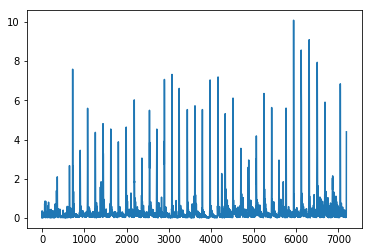

In [133]:
sodf = SpectralOnsetProcessor(onset_method='superflux', fps=fps,
                                      filterbank=LogarithmicFilterbank,
                                      num_bands=24, log=np.log10)
sodf_onsets = sodf(audio_filename)
plt.plot(sodf_onsets)
plt.show()

# Discrete derivative of smoothed RMS (robust, but timing is imprecise)

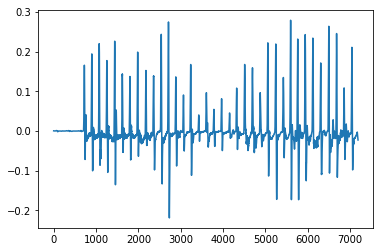

In [134]:
rms, cs = rms_centroids(audio_filename, frameSize=1024, hopSize=hopSize, sampleRate=fs)
rms = signal.smooth(rms, int(fs / hopSize * 0.2))
rms = preprocessing.scale(rms, with_mean=False, copy=False)
rms = rms[1:] - rms[:-1]

plt.plot(rms)
plt.show()


# Filtered SODF

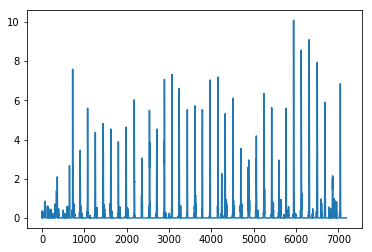

In [135]:
sodf_onsets[rms <= 0] = 0
plt.plot(sodf_onsets)
plt.show()

# Detected peaks

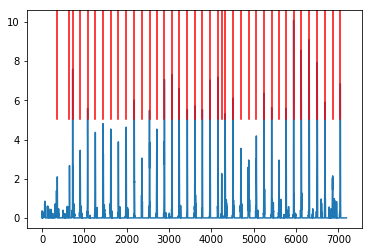

In [136]:
proc = OnsetPeakPickingProcessor(
    fps=fps, threshold=onset_threshold)
p_onsets = proc(sodf_onsets)
# combine close events (e.g., several strings onsets in guitar chord), keep the last one
p_onsets = combine_series(p_onsets, series_delta)

plt.plot(sodf_onsets)
for xc in p_onsets:
    plt.axvline(x=xc*fps, color="r", ymin=0.5, ymax=1)
plt.show()

# Detcted Peaks and Spectral Centroids. Spectral centroid goes down after "True" attacks.

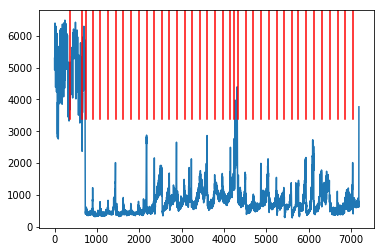

In [137]:
plt.plot(cs)
for xc in p_onsets:
    plt.axvline(x=xc*fps, color="r", ymin=0.5, ymax=1)
plt.show()

# Attacks candidates and  AFTER-attack-averaged-centroids 

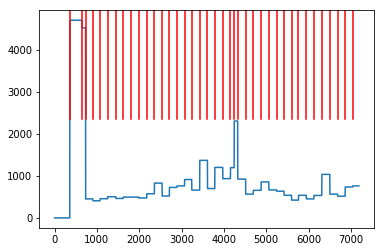

In [138]:
smoothed = []
for i in range(len(p_onsets)):
    onset = p_onsets[i]
    duration = 0.5
    if (i < len(p_onsets) - 1):
        duration = min((p_onsets[i + 1] - p_onsets[i]), duration)
    window_len = int(duration * fs / hopSize)
    s = int(float(onset) * fs / hopSize)
    d = min(window_len, len(cs) - s)
    w = eval('np.hanning(2*d)')
    w = w[d:] / np.sum(w[d:])
    w = np.reshape(w, (1, d))
    c = cs[s:s + d]
    smoothed.append(np.dot(w, c)[0])

conditions = []
onsets = np.concatenate((p_onsets, [1000]))
funcs = np.concatenate((smoothed, [0]))
for i in range(len(cs)):
    conditions.append((onsets[:-1] <= float(i)/fps) & (onsets[1:] > float(i)/fps))
plt.plot(np.piecewise(range(len(cs)), np.array(conditions).transpose(), funcs))
#plt.plot(cs)
for xc in p_onsets:
    plt.axvline(x=xc*float(fs)/hopSize, color="r", ymin=0.5, ymax=1)
plt.show()

# Eliminate attacks with spectral centroid > 3500. It still has false positives ("released string" sound)

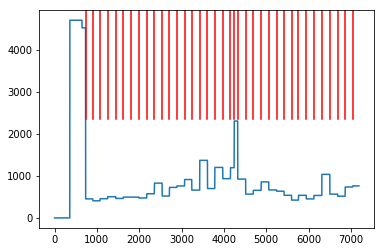

In [139]:
max_spectral_centroid = 3500
result = []
for i in range(len(p_onsets)):
    if smoothed[i] < max_spectral_centroid:
        result.append(p_onsets[i])
plt.plot(np.piecewise(range(len(cs)), np.array(conditions).transpose(), funcs))
#plt.plot(cs)
for xc in result:
    plt.axvline(x=xc*float(fs)/hopSize, color="r", ymin=0.5, ymax=1)
plt.show() 

# Eliminate attacks with spectral centroid > 2000. It's good for this sample, but on average, it gives too many false negatives in other files. That's whay I'm looking for more sophisticated decision.

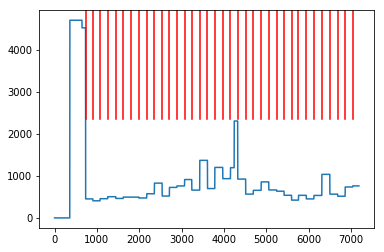

In [140]:
max_spectral_centroid = 2000
result = []
for i in range(len(p_onsets)):
    if smoothed[i] < max_spectral_centroid:
        result.append(p_onsets[i])
plt.plot(np.piecewise(range(len(cs)), np.array(conditions).transpose(), funcs))
#plt.plot(cs)
for xc in result:
    plt.axvline(x=xc*float(fs)/hopSize, color="r", ymin=0.5, ymax=1)
plt.show() 